# **Homework 15 - Reinforcement Learning**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com



## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

最後，引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

In [2]:
%%capture
import gym
env = gym.make('LunarLander-v2')

## Policy Gradient

現在來搭建一個簡單的 policy network。
我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [3]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

# class PolicyGradientNetwork(nn.Module):

#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(8, 16)
#         self.fc2 = nn.Linear(16, 16)
#         self.fc3 = nn.Linear(16, 4)

#     def forward(self, state):
#         hid = torch.tanh(self.fc1(state))
#         hid = torch.tanh(self.fc2(hid))
#         return F.softmax(self.fc3(hid), dim=-1)

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [4]:
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
#         self.optimizer = optim.Adam(self.network.parameters())
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

## Critic

In [5]:
class CriticNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state):
        x = torch.tanh(self.fc1(state))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class Critic():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
        self.mseLoss = nn.MSELoss()
        
    def learn(self, pred_rewards, final_rewards):
        loss = ((pred_rewards - final_rewards)**2).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

#     def learn(self, advantages):
#         loss = (advantages**2).sum()

#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()

    def predict(self, state):
        base_score = self.network(torch.FloatTensor(state))
        
        return base_score

## 訓練 Agent

現在我們開始訓練 actor。
透過讓 actor 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [7]:
# def compute_returns(next_value, rewards, masks, gamma=0.99):
#     R = next_value
#     returns = []
#     for step in reversed(range(len(rewards))):
#         R = rewards[step] + gamma * R * masks[step]
#         returns.insert(0, R)
#     return returns


In [8]:
# from itertools import count

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ## Create Models
# # actor = PolicyGradientNetwork().to(device)
# # critic = CriticNetwork().to(device)
# actor = PolicyGradientNetwork()
# critic = CriticNetwork()


# ## Create Optimizers
# # optimizerA = optim.Adam(actor.parameters())
# # optimizerC = optim.Adam(critic.parameters())
# optimizerA = optim.SGD(actor.parameters(), lr=0.001)
# optimizerC = optim.SGD(critic.parameters(), lr=0.001)

# actor.train()
# critic.train()

# EPISODE_PER_BATCH = 20  # 每蒐集 5 個 episodes 更新一次 actor
# NUM_BATCH = 400       # 總共更新 400 次

# avg_total_rewards, avg_final_rewards = [], []

# prg_bar = tqdm(range(NUM_BATCH))
# for batch in prg_bar:
    
#     actor_loss = 0
#     critic_loss = 0
    
#     for episode in range(EPISODE_PER_BATCH):
#         state = env.reset()
#         log_probs = []
#         values = []
#         rewards = []
#         masks = []

#         for i in count():

#             ## Get action from actor and value 
# #             state = torch.FloatTensor(state).to(device)
#             state = torch.FloatTensor(state)
#             value = critic(state)

#             action_prob = actor(state)        
#             dist = Categorical(action_prob)

#             action = dist.sample()
#             log_prob = dist.log_prob(action).unsqueeze(0)

#             ## Update env and get reward
#             next_state, reward, done, _ = env.step(action.cpu().numpy())

#             ## Record infors: log_porbs, values, rewards, masks
#             log_probs.append(log_prob)
#             values.append(value)
# #             rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
# #             masks.append(torch.tensor([1-done], dtype=torch.float, device=device))
#             rewards.append(torch.tensor([reward], dtype=torch.float))
#             masks.append(torch.tensor([1-done], dtype=torch.float))

#             ## Update state
#             state = next_state

#             if done:
#                 break


# #         next_state = torch.FloatTensor(next_state).to(device)
#         next_state = torch.FloatTensor(next_state)
#         next_value = critic(next_state)
#         returns = compute_returns(next_value, rewards, masks)

#         log_probs = torch.cat(log_probs)
#         returns = torch.cat(returns).detach()
#         values = torch.cat(values)

#         advantage = returns - values

#         ## Caculate loss
#         actor_loss += -(log_probs * advantage.detach()).mean()
#         critic_loss += advantage.pow(2).mean()
    
#     ## Update model
#     actor_avg_loss = actor_loss / EPISODE_PER_BATCH
#     critic_avg_loss = critic_loss / EPISODE_PER_BATCH
    
#     optimizerA.zero_grad()
#     optimizerC.zero_grad()
#     actor_avg_loss.backward()
#     critic_avg_loss.backward()
#     optimizerA.step()
#     optimizerC.step()
    
#     total_reward = sum(rewards)
#     final_reward = reward
#     avg_total_rewards.append(total_reward)
#     avg_final_rewards.append(final_reward)
    
#     prg_bar.set_description(f"Total: {total_reward[0]: 4.1f}, Final: {reward: 4.1f}")
    
# torch.save(actor, 'model/actor.pkl')
# torch.save(critic, 'model/critic.pkl')
# env.close()


### Ori

In [9]:
network = PolicyGradientNetwork()
actor = PolicyGradientAgent(network)

## If add critic
critic_network = CriticNetwork()
critic = Critic(critic_network)

In [10]:
actor.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 20  # 每蒐集 5 個 episodes 更新一次 actor
NUM_BATCH = 400        # 總共更新 400 次

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0

        while True:

            action, log_prob = actor.sample(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                rewards.append(np.full(total_step, total_reward))  # 設定同一個 episode 每個 action 的 reward 都是 total reward
                break

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    
    actor.learn(torch.stack(log_probs), torch.from_numpy(rewards))

### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

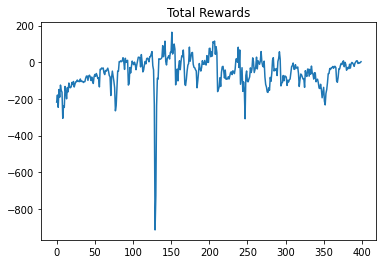

In [11]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

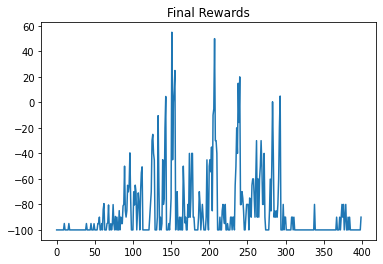

In [12]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## 測試

In [13]:
# actor.network.eval()  # 測試前先將 network 切換為 evaluation 模式

# state = env.reset()

# img = plt.imshow(env.render(mode='rgb_array'))

# total_reward = 0

# done = False
# while not done:
#     action, _ = actor.sample(state)
#     state, reward, done, _ = env.step(action)

#     total_reward += reward

#     img.set_data(env.render(mode='rgb_array'))
#     display.display(plt.gcf())
#     display.clear_output(wait=True)

In [14]:
print(total_reward)

273.34133247620673


In [15]:
print(reward)

100


## 參考資料

以下是一些有用的參考資料。
建議同學們實做前，可以先參考第一則連結的上課影片。
在影片的最後有提到兩個有用的 Tips，這對於本次作業的實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
